In [1]:
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import gc
#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
import json

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import sklearn

In [3]:
print(np.__version__)
print(pd.__version__)
print(json.__version__)
print(sklearn.__version__)
print(cab.__version__)

1.17.0
1.1.3
2.0.9
0.19.1
0.24.2


In [4]:
entprise_train = pd.read_csv('train/entprise_info.csv',engine='python')
base_info = pd.read_csv('train/base_info.csv',engine='python',encoding='utf-8')
entprise_test = pd.read_csv('entprise_evaluate.csv')
reccap_predict = pd.read_csv('reccap_predict.csv')['reccap']
empnum_predict = pd.read_csv('empnum_predict.csv')['empnum']

In [5]:
entprise = pd.concat([entprise_train,entprise_test])
data = pd.merge(entprise,base_info,on='id')
data.drop(['ptbusscope','midpreindcode','score'],axis=1,inplace=True)

## 观察数据信息

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24865 entries, 0 to 24864
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             24865 non-null  object 
 1   label          14865 non-null  float64
 2   oplocdistrict  24865 non-null  int64  
 3   industryphy    24865 non-null  object 
 4   industryco     24864 non-null  float64
 5   dom            24865 non-null  object 
 6   opscope        24865 non-null  object 
 7   enttype        24865 non-null  int64  
 8   enttypeitem    16651 non-null  float64
 9   opfrom         24865 non-null  object 
 10  opto           8825 non-null   object 
 11  state          24865 non-null  int64  
 12  orgid          24865 non-null  int64  
 13  jobid          24865 non-null  int64  
 14  adbusign       24865 non-null  int64  
 15  townsign       24865 non-null  int64  
 16  regtype        24865 non-null  int64  
 17  empnum         19615 non-null  float64
 18  compfo

## EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

## 正负样本比例图

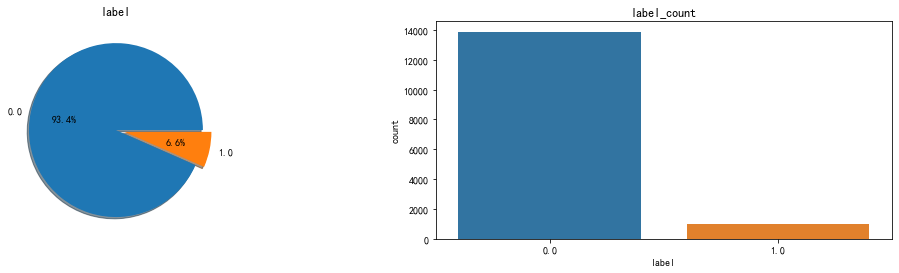

In [8]:
f,ax = plt.subplots(1,2,figsize=(18,4))
data1 = data[data['label'].notnull()]
data1['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('label')
ax[0].set_ylabel("")
sns.countplot('label',data=data1,ax=ax[1])
ax[1].set_title("label_count")
plt.show()

## 对是否城镇和非法集资进行可视化探索

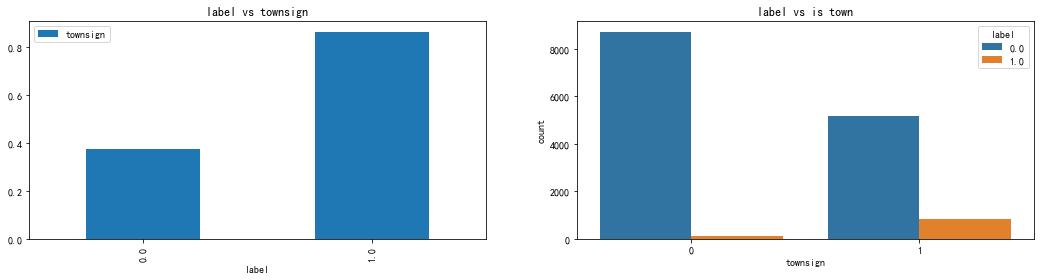

In [9]:
f,ax = plt.subplots(1,2,figsize=(18,4))
data1[['label','townsign']].groupby('label').mean().plot.bar(ax=ax[0])
ax[0].set_title("label vs townsign")
sns.countplot('townsign',hue='label',data=data1,ax=ax[1])
ax[1].set_title("label vs is town")
plt.show()

# 企业状态和是否非法集资的关系

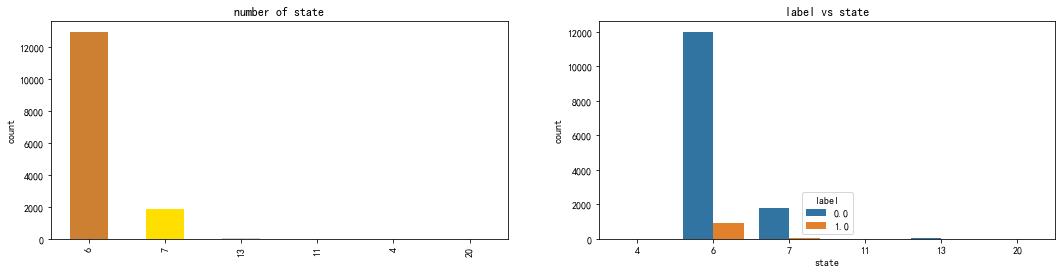

In [10]:
f,ax = plt.subplots(1,2,figsize=(18,4))
data1['state'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title("number of state")
ax[0].set_ylabel("count")
sns.countplot('state',hue='label',data=data1,ax=ax[1])
ax[1].set_title("label vs state")
plt.show()

In [11]:
pd.crosstab([data1.townsign,data1.label],data1.state,margins=True).style.background_gradient(cmap='summer_r')

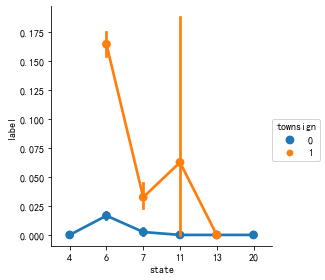

In [12]:
sns.factorplot('state','label',hue='townsign',data=data1)
plt.show()

## 企业状态和企业行业细类代码与是否非法集资的关系

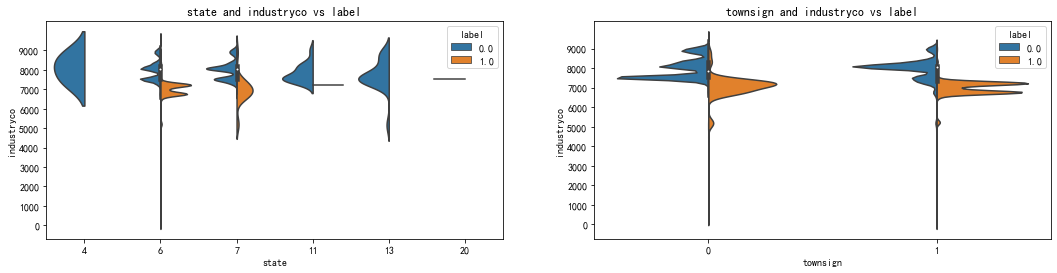

In [13]:
f,ax = plt.subplots(1,2,figsize=(18,4))
sns.violinplot("state",'industryco',hue='label',data=data1,split=True,ax=ax[0])
ax[0].set_title("state and industryco vs label")
ax[0].set_yticks(range(0,10000,1000))
sns.violinplot('townsign','industryco',hue='label',data=data1,split=True,ax=ax[1])
ax[1].set_title('townsign and industryco vs label')
ax[1].set_yticks(range(0,10000,1000))
plt.show()

## 行业代码细类与是否非法集资企业的关系

In [14]:
from sklearn.preprocessing import LabelEncoder
labelencoder1 = LabelEncoder()
data['industryphy'] = labelencoder1.fit_transform(data['industryphy'])

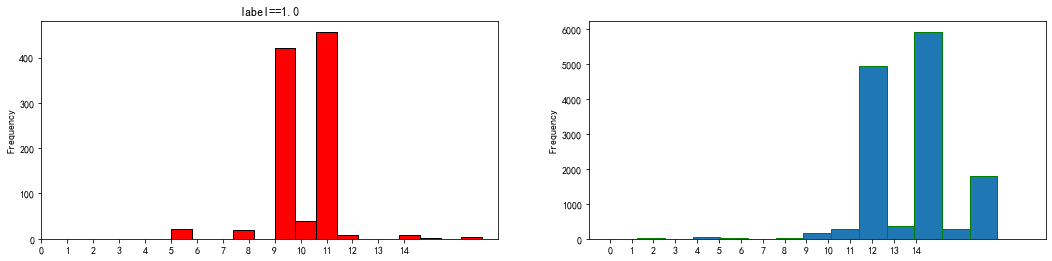

In [15]:
f,ax = plt.subplots(1,2,figsize=(18,4))
data[data['label']==1.0].industryphy.plot.hist(ax=ax[0],bins=15,edgecolor='black',color='red')
ax[0].set_title('label==1.0')
x1 = list(range(15))
ax[0].set_xticks(x1)
data[data['label']==0.0].industryphy.plot.hist(ax=ax[1],bins=15,edgecolor='green')
x2 = list(range(15))
ax[0].set_title('label==1.0')
ax[1].set_xticks(x2)
plt.show()

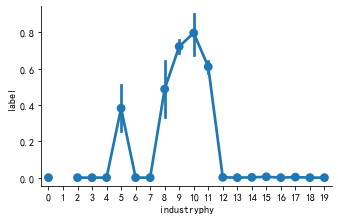

In [16]:
sns.factorplot('industryphy','label',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

In [17]:
entprise = pd.concat([entprise_train,entprise_test])
data = pd.merge(entprise,base_info,on='id')
data.drop(['ptbusscope','midpreindcode','score'],axis=1,inplace=True)

In [28]:
data[['enttypeitem','enttypeminu','enttypegb']]

,enttypeitem,enttypeminu,enttypegb
0,4530,4533,4533
1,9600,9600,9600
2,1130,1130,1130
3,1150,1151,1151
4,9600,9600,9600
...,...,...,...
24860,1150,1151,1151
24861,1130,1130,1130
24862,6110,6110,6110
24863,1130,1130,1130


In [18]:
data['enttypeitem'] = data['enttypegb']//10*10
data['enttypeminu'] = data['enttypegb']
data['regcap'] = data['regcap'].fillna(data['regcap'].mean())
data['reccap'] = reccap_predict
data['empnum'] = empnum_predict
data['reccap'] = data['reccap']
data['opform'].fillna(10,inplace=True)
data['opform'] = data['opform'].astype(str)
from sklearn.preprocessing import LabelEncoder
labelencoder1 = LabelEncoder()
labelencoder2 = LabelEncoder()
labelencoder3 = LabelEncoder()
labelencoder4 = LabelEncoder()
data['opform'] = labelencoder1.fit_transform(data['opform'])
data['oploc'] = labelencoder2.fit_transform(data['oploc'])
data['industryphy'] = labelencoder3.fit_transform(data['industryphy'])
data['oplocdistrict'] = labelencoder4.fit_transform(data['oplocdistrict'])
def opto_process(x):
    if len(x)>3:
        return x[:4]
    else:
        return x
data['opfrom'] = data['opfrom'].map(lambda x:x[:4])
data['opto'].fillna('nan',inplace=True)
data['opto'] = data['opto'].map(opto_process)
data['opfrom'] = data['opfrom'].astype(int)
data['opto'] = data['opto'].astype(float)
data['industryco'] = data['industryco'].fillna(data['industryco'].mean())
data.loc[data['opto'].isnull(),"opto"] = data[data['opto'].isnull()]['opfrom']+50.0
data['enttpe_year'] = data['opfrom'] - data['opto']
data['opscope'] = data['opscope'].apply(lambda x:x.replace("、","/").replace("；","/").replace("，","/").replace("。","/"))
data['opscope'] = data['opscope'].apply(lambda x:x.replace("（","/").replace("）","/").replace("，","/").replace("。","/"))
data['opscope'] = data['opscope'].apply(lambda x:"".join(x.split("/")))
import jieba
data['opscope_1'] = data['opscope'].apply(lambda x:jieba.lcut(x,cut_all=True))
from collections import Counter
def jieba_func(x):
    str1 = list(Counter(x).keys())[0]
    str2 = list(Counter(x).keys())[1]
    count = str1+str2
    return count
data['count_opscope'] = data['opscope'].apply(lambda x:jieba_func(x))
le6 = LabelEncoder()
data['opscope_length'] = data['opscope_1'].apply(lambda x:len(x))
# data['opscope'] = data['opscope'].apply(lambda x:x.split('/')[-2:])
data['opscope_label'] = le6.fit_transform(data['count_opscope'])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.563 seconds.
Prefix dict has been built successfully.


In [19]:
def bucket(name,bucket_len):
    gap_list=[data[name].quantile(i/bucket_len) for i in range(bucket_len+1)]
    len_data=len(data[name])
    new_col=[]
    for i in data[name].values:
        for j in range(len(gap_list)):
            if gap_list[j]>=i:
                encode=j
                break
        new_col.append(encode)
    return new_col
#注册资本_实缴资本
data['regcap_reccap']=data['regcap']-data['reccap']
#注册资本分桶
data['regcap']=data['regcap'].fillna(data['regcap'].median())
data['bucket_regcap']=bucket('regcap',5)
#实缴资本分桶
data['reccap']=data['reccap'].fillna(data['reccap'].median())
data['bucket_reccap']=bucket('reccap',5)
#注册资本_实缴资本分桶
data['regcap_reccap']=data['regcap_reccap'].fillna(data['regcap_reccap'].median())
data['bucket_regcap_reccap']=bucket('regcap_reccap',5)
print('分桶完毕.................')

分桶完毕.................


In [20]:
# data['dom'] = data['dom'].apply(lambda x:x[:16])
le7 = LabelEncoder()
data['dom'] = le7.fit_transform(data['dom'])

In [21]:
from tqdm import tqdm
def cross_two(name_1,name_2):
    new_col=[]
    encode=0
    dic={}
    val_1=data[name_1]
    val_2=data[name_2]
    for i in tqdm(range(len(val_1))):
        tmp=str(val_1[i])+'_'+str(val_2[i])
        if tmp in dic:
            new_col.append(dic[tmp])
        else:
            dic[tmp]=encode
            new_col.append(encode)
            encode+=1
    return new_col
#作企业类型-小类的交叉特征
data['enttypegb']=data['enttypegb'].fillna("无")
data['enttypeitem']=data['enttypeitem'].fillna("无")
new_col=cross_two('enttypegb','enttypeitem')#作企业类型-小类的交叉特征
data['enttypegb_enttypeitem']=new_col
#
#行业类别-细类的交叉特征
data['industryphy']=data['industryphy'].fillna("无")
data['industryco']=data['industryco'].fillna("无")
new_col=cross_two('industryphy','industryco')#作企业类型-小类的交叉特征
data['industryphy_industryco']=new_col
#企业类型-行业类别的交叉特征
new_col=cross_two('enttypegb','industryphy')#作企业类型-小类的交叉特征
data['enttypegb_industryphy']=new_col
#行业类别-企业类型小类的交叉特征
new_col=cross_two('industryphy','enttypeitem')#作企业类型-小类的交叉特征
data['industryphy_enttypeitem']=new_col
#行业类别细类--企业类型小类的交叉特征
new_col=cross_two('industryco','enttypeitem')#作企业类型-小类的交叉特征
data['industryco_enttypeitem']=new_col

#企业类型-小类-行业类别-细类的交叉特征
new_col=cross_two('enttypegb_enttypeitem','industryphy_industryco')#作企业类型-小类的交叉特征
data['enttypegb_enttypeitem_industryphy_industryco']=new_col

100%|████████████████████████████████████████████████████████████████████████| 24865/24865 [00:00<00:00, 130064.74it/s]


In [22]:
for fea in ['industryphy','enttype','enttypeitem','empnum','opfrom','regcap','reccap','opto','enttypeminu']:
    data[fea+'_counts'] = data.groupby([fea])['id'].transform('count')

In [23]:
x_train = data[data['label'].notnull()]
y_train = x_train['label']
x_test = data[data['label'].isnull()]
features_name = [i for i in data.columns if i not in ['id','regcap','reccap','enttype','enttypeitem','enttypeminu','bucket_regcap_reccap','townsign','count_opscope','opscope_1','oplocdistrict','adbusign','compform','opform','orgid','exenum','opscope','enttypegb','label','state','jobid','regtype','parnum','venind','protype','oploc','forreccap','forregcap','congro']]
#features_name = ['industryco', 'dom', 'opfrom', 'opto', 'empnum', 'enttpe_year', 'opscope_length', 'opscope_label', 'regcap_reccap', 'bucket_regcap', 'bucket_reccap', 'enttypegb_enttypeitem', 'industryphy_industryco', 'enttypegb_industryphy', 'industryphy_enttypeitem', 'industryco_enttypeitem', 'enttypegb_enttypeitem_industryphy_industryco', 'industryphy_counts', 'enttype_counts', 'enttypeitem_counts', 'empnum_counts', 'regcap_counts', 'opto_counts']
x_train = x_train[features_name]
x_test = x_test[features_name]

In [24]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14865 to 24864
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   industryphy                                   10000 non-null  int64  
 1   industryco                                    10000 non-null  float64
 2   dom                                           10000 non-null  int64  
 3   opfrom                                        10000 non-null  int32  
 4   opto                                          10000 non-null  float64
 5   empnum                                        10000 non-null  float64
 6   enttpe_year                                   10000 non-null  float64
 7   opscope_length                                10000 non-null  int64  
 8   opscope_label                                 10000 non-null  int64  
 9   regcap_reccap                                 10000 non-n

In [25]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
# 模型
rf = RandomForestClassifier(oob_score=True, random_state=2020,
            n_estimators= 60,max_depth=13,min_samples_split=10)
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
def score_fuc(p,r):
    return 2*p*r/(p+r)
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
result_test = pd.DataFrame()
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    rf.fit(tf, tt)
    pre_train = rf.predict(tf)
    stat_pre_train = stat_func(pre_train)
    p = precision_score(tt,stat_pre_train)
    r = recall_score(tt,stat_pre_train)
    score = score_fuc(p,r)
    #score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = rf.predict(df)
    stat_pre = stat_func(pre)
    p = precision_score(dt,stat_pre)
    r = recall_score(dt,stat_pre)
    score = score_fuc(p,r)
    devscore.append(score)
    print("Valid F1：%s"%score)
    result_test[str(count-1)+"折"] = rf.predict(x_test)/5
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']
result = result_test['result'].values
result_1 = stat_func(result)

************************************ 1 ************************************
train F1：0.9341692789968652
Valid F1：0.8311688311688311
************************************ 2 ************************************
train F1：0.9280575539568344
Valid F1：0.8214285714285714
************************************ 3 ************************************
train F1：0.9339263024142314
Valid F1：0.8564814814814816
************************************ 4 ************************************
train F1：0.935483870967742
Valid F1：0.8704156479217604
************************************ 5 ************************************
train F1：0.9373401534526854
Valid F1：0.8517647058823529
Train average F1：0.9337954319576717 Valid average F1：0.8462518475765994


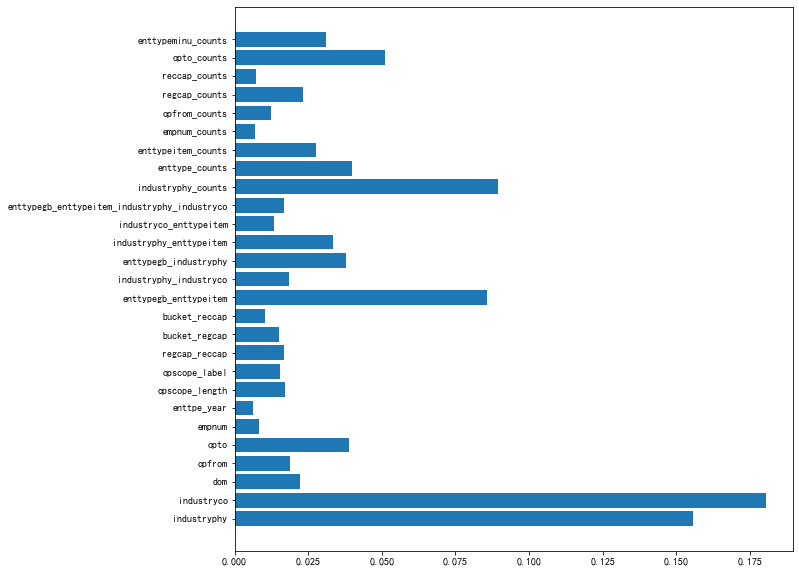

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
a = pd.DataFrame()
feature_import = rf.feature_importances_
feature_name  = x_train.columns.tolist()
plt.barh(feature_name,feature_import)
plt.show()

In [1]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'../result/1116_1_1.csv', index=False)

NameError: name 'pd' is not defined